In [49]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes
## for statistical tests
import scipy
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
# from lime import lime_tabular
import matplotlib.ticker as plticker
import pickle
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.linear_model import SGDClassifier

In [50]:
#Predit on the test set
dfs = pd.read_csv("train.csv")
dfs.head()

Id  Marital status  Application mode  Application order  Course  \
0  3222               1                 1                  1      14   
1  2388               1                 8                  4       9   
2  1865               1                12                  1      17   
3   652               1                12                  1      12   
4  4220               1                 1                  1      14   

   Daytime/evening attendance  Previous qualification  Nacionality  \
0                           1                       1            1   
1                           1                       1            1   
2                           0                       1            1   
3                           1                      12            1   
4                           1                       1            1   

   Mother's qualification  Father's qualification  ...  \
0                      13                      28  ...   
1                      23                      14  ...   
2                       1                       1  ...   
3                       1                       5  ...   
4                      19                      28  ...   

   Curricular units 2nd sem (credited)  Curricular units 2nd sem (enrolled)  \
0                                    0                                    6   
1                                    0                                    5   
2                                    0                                    5   
3                                    0                                    8   
4                                    0                                    5   

   Curricular units 2nd sem (evaluations)  \
0                                       7   
1                                      10   
2                                       5   
3                                      11   
4                                       5   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    6                         14.714286   
1                                    2                         12.500000   
2                                    5                         12.400000   
3                                    7                         12.614286   
4                                    0                          0.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               11.1   
1                                               0               11.1   
2                                               0               15.5   
3                                               0               12.7   
4                                               0                9.4   

   Inflation rate   GDP  Category  
0             0.6  2.02  Graduate  
1             0.6  2.02   Dropout  
2             2.8 -4.06  Graduate  
3             3.7 -1.70  Graduate  
4            -0.8 -3.12   Dropout  

[5 rows x 36 columns]

In [51]:
#ENCODING
dfs = pd.get_dummies(dfs, columns=['Marital status'])
dfs = pd.get_dummies(dfs, columns=['Application mode'])
dfs = pd.get_dummies(dfs, columns=['Course'])
dfs = pd.get_dummies(dfs, columns=['Previous qualification'])
dfs = pd.get_dummies(dfs, columns=['Nacionality'])
dfs = pd.get_dummies(dfs, columns=["Mother's occupation"])
dfs = pd.get_dummies(dfs, columns=["Father's occupation"])

#DROP AND CREATE
dfs = dfs.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfs["valid_enroll_sem2"] = dfs["Curricular units 2nd sem (enrolled)"] - dfs["Curricular units 2nd sem (approved)"]
dfs["valid_enroll_sem1"] = dfs["Curricular units 1st sem (enrolled)"] - dfs["Curricular units 1st sem (approved)"]
dfs["gap_enroll_valid"] = dfs["valid_enroll_sem1"] - dfs["valid_enroll_sem2"]


#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfs.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfs.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfs["Category"]
dtf_scaled["Id"] = dfs["Id"]
dfs = dtf_scaled

#features selection
df = dfs[["Id", 
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder", 
"Category"]]

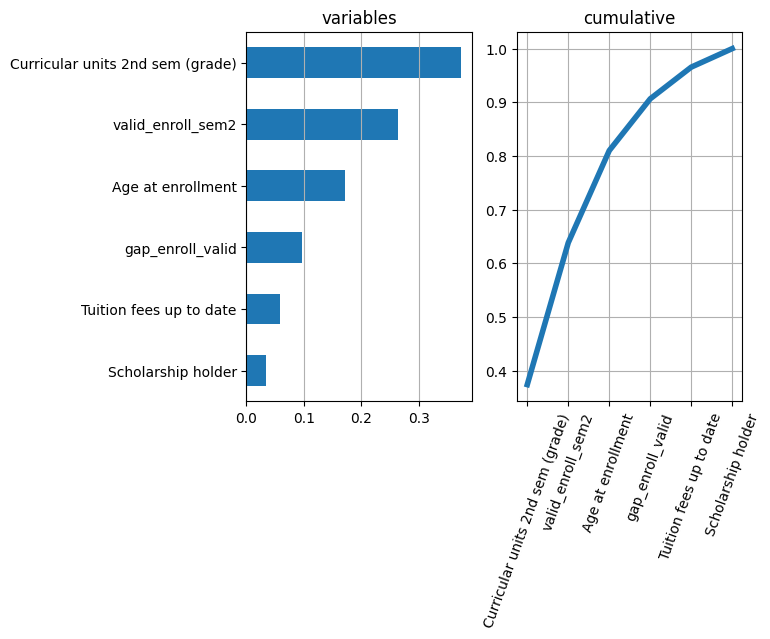

IMPORTANCE    cumsum
VARIABLE                                              
Curricular units 2nd sem (grade)    0.373890  0.373890
valid_enroll_sem2                   0.264374  0.638264
Age at enrollment                   0.171721  0.809986
gap_enroll_valid                    0.096467  0.906453
Tuition fees up to date             0.059055  0.965508
Scholarship holder                  0.034492  1.000000

In [52]:
# Plot
X = df.drop(["Category", "Id"], axis=1).values
y = df["Category"].values
feature_names = df.drop(["Category", "Id"], axis=1).columns

model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas df
dfs_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False).nlargest(30,"IMPORTANCE")
dfs_importances['cumsum'] = dfs_importances['IMPORTANCE'].cumsum(axis=0)
dfs_importances = dfs_importances.set_index("VARIABLE")
    
## Plot

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].title.set_text('variables')
dfs_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dfs_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dfs_importances)), xticklabels=dfs_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()
dfs_importances.head(30)

In [53]:
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k="all").fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=6).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
plt.figure(figsize=(8,5))
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

<AxesSubplot: xlabel='selection', ylabel='features'>

Text(0.5, 1.0, 'pearson correlation')

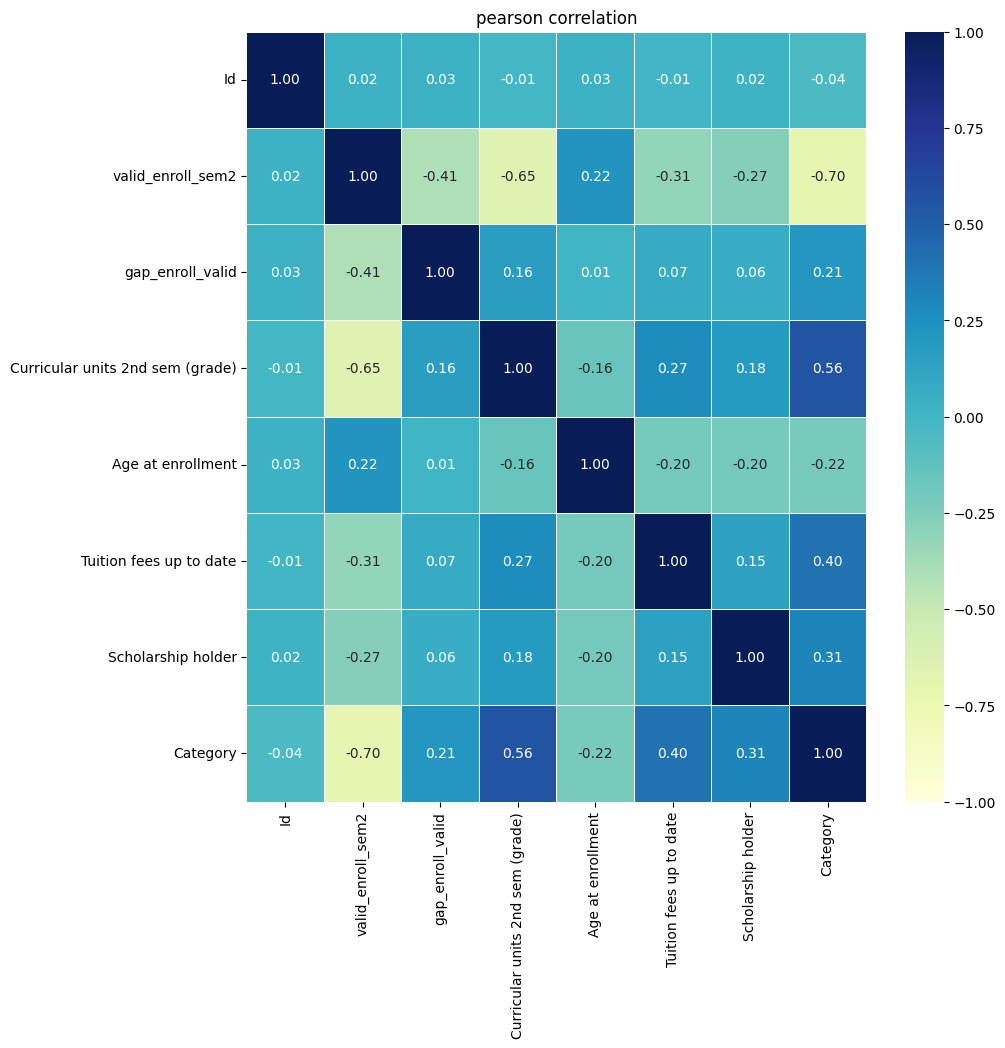

In [54]:
corr_matrix = df.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [55]:
X_names = ["valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder"
]

X_train = dfs[X_names].values
y_train = dfs["Category"].values
# Instantiate SVM classifier using SGDClassifier
svm = SGDClassifier(loss='hinge')
 
# Fit the model
svm.fit(X_train, y_train)
filename = 'finalized_model_academic_V6.sav'
pickle.dump(svm, open(filename, 'wb'))

In [56]:
# validation
dfv = pd.read_csv("validation.csv")

#ENCODING
dfv = pd.get_dummies(dfv, columns=['Marital status'])
dfv = pd.get_dummies(dfv, columns=['Application mode'])
dfv = pd.get_dummies(dfv, columns=['Course'])
dfv = pd.get_dummies(dfv, columns=['Previous qualification'])
dfv = pd.get_dummies(dfv, columns=['Nacionality'])
dfv = pd.get_dummies(dfv, columns=["Mother's occupation"])
dfv = pd.get_dummies(dfv, columns=["Father's occupation"])

#DROP AND CREATE
dfv = dfv.drop(["Mother's qualification", "Father's qualification"], axis=1)
dfv["valid_enroll_sem2"] = dfv["Curricular units 2nd sem (enrolled)"] - dfv["Curricular units 2nd sem (approved)"]
dfv["valid_enroll_sem1"] = dfv["Curricular units 1st sem (enrolled)"] - dfv["Curricular units 1st sem (approved)"]
dfv["gap_enroll_valid"] = dfv["valid_enroll_sem1"] - dfv["valid_enroll_sem2"]

#MinMax-Scaler
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dfv.drop(["Category","Id"], axis=1))
dtf_scaled= pd.DataFrame(X, columns=dfv.drop(["Category","Id"], axis=1).columns)
dtf_scaled["Category"] = dfv["Category"]
dtf_scaled["Id"] = dfv["Id"]
dfv = dtf_scaled

#features selection
dfv = dfv[["Id",
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder",
"Category"]]

#Validation score see

X_validation = dfv[[
"valid_enroll_sem2", 
"gap_enroll_valid",
"Curricular units 2nd sem (grade)",
"Age at enrollment",
"Tuition fees up to date",
"Scholarship holder"
]].values
y_validation = dfv["Category"].values

loaded_model = pickle.load(open("finalized_model_academic_V6.sav", 'rb'))
result = loaded_model.score(X_validation, y_validation)
print(result)


0.7251506024096386
